In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
%matplotlib inline
plt.style.use('ggplot')

import time
import datetime

#노트북 안에 그래프 그리기 위해
%matplotlib inline

#그래프에서 격자로 숫자범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)

#import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# import workalendar
# from workalendar.america import Brazil

In [2]:
%%time
test =pd.read_csv("D:/Data/elo/test.csv", parse_dates=['first_active_month']) 
train = pd.read_csv("D:/Data/elo/train.csv", parse_dates=['first_active_month'])
hist =pd.read_csv("D:/Data/elo/historical_transactions.csv") 
merchant = pd.read_csv("D:/Data/elo/merchants.csv")
submission = pd.read_csv('D:/Data/elo/sample_submission.csv')
train.head()

Wall time: 1min 39s


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [3]:
%%time
test =pd.read_csv("D:/Data/elo/test.csv", parse_dates=['first_active_month']) 
train = pd.read_csv("D:/Data/elo/train.csv", parse_dates=['first_active_month'])
submission = pd.read_csv('D:/Data/elo/sample_submission.csv')

Wall time: 865 ms


In [4]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')
train.head()


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB


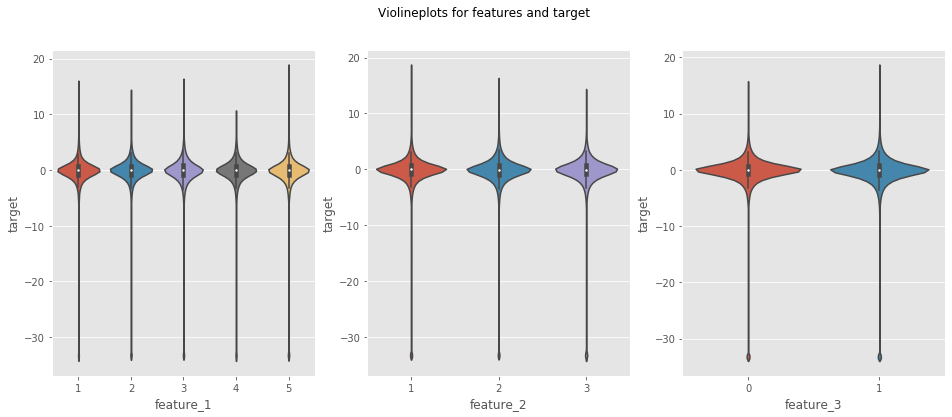

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1');
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2');
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3');

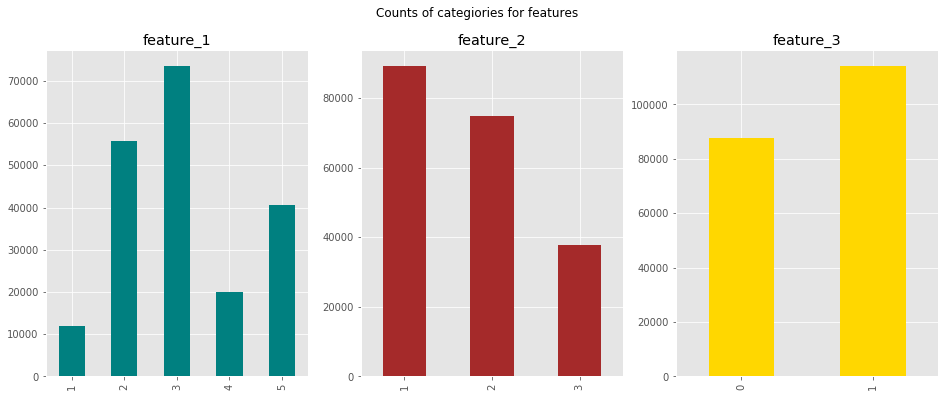

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('Counts of categiories for features');

## 2개의 플롯에서 중요한 아이디어를 얻을 수있다. 

## 데이터가 정규분포로 부터 샘플링 됐다는 것을 알 수 있다.

In [8]:
test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

In [9]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [10]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = test.loc[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1), 'first_active_month'].min()

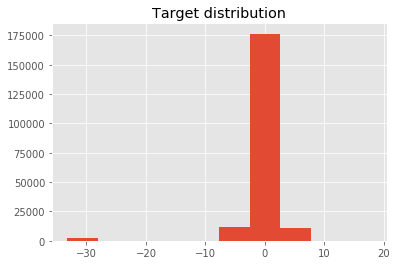

In [11]:
plt.hist(train['target']);
plt.title('Target distribution');

In [12]:
print('There are {0} samples with target lower than -20.'.format(train.loc[train.target < -20].shape[0]))

There are 2207 samples with target lower than -20.


In [13]:
max_date = train['first_active_month'].dt.date.max()
def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [14]:
train = process_main(train)
test = process_main(test)

##  historical_transactions
### -카드아이디 당 값 

In [15]:
historical_transactions = pd.read_csv('D:/Data/elo/historical_transactions.csv')
e = pd.read_excel('D:/Data/elo/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [16]:
print(f'{historical_transactions.shape[0]} samples in data')
historical_transactions.head()

29112361 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [17]:
# autorized_flag를 이진수로 변환 합시다.
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

At average 91.3545% transactions are authorized


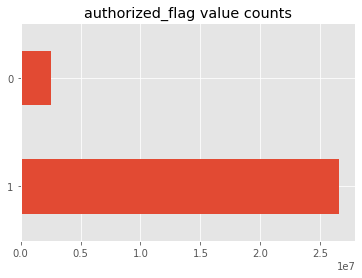

In [18]:
print(f"At average {historical_transactions['authorized_flag'].mean() * 100:.4f}% transactions are authorized")
historical_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

## 승인된 카드 거래 높고 낮음

In [19]:
autorized_card_rate = historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

## 대부분의 거래가 거절된 카드도 있었다

In [20]:
autorized_card_rate.tail()

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

# 분할납부

In [21]:
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

### 일반적으로 할부는 0과 1로 표현되는 듯 하지만 -1 ~ 999까지의 숫자는 이상하다. 
### 아마 빈 값을 채우기 위한 값일 것이다 

In [22]:
historical_transactions.groupby(['installments'])['authorized_flag'].mean()

installments
-1      0.885692
 0      0.928032
 1      0.907024
 2      0.884020
 3      0.862254
 4      0.819903
 5      0.809183
 6      0.779732
 7      0.693196
 8      0.692439
 9      0.663721
 10     0.702021
 11     0.660241
 12     0.653694
 999    0.031915
Name: authorized_flag, dtype: float64

## 할부수가 많을 수록 승인률이 낮다
### 0과 1외의 거래량 중에 3%만 승인되엇다는 점을 고려할 때 999는 사기 거래를 의미할 수 있는 것으로 보임

In [23]:
historical_transactions['installments'] = historical_transactions['installments'].astype('category')

In [24]:
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])

## purchase_amount
### 매입_금액이 정상화되었다. 그래도 한번봐보자

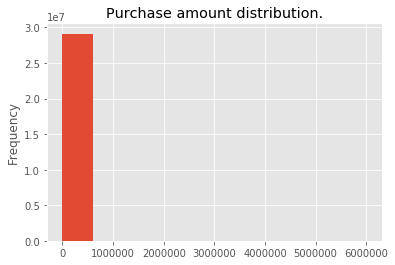

In [25]:
plt.title('Purchase amount distribution.');
historical_transactions['purchase_amount'].plot(kind='hist');

In [26]:
# for i in [-1, 0]:
#     n = historical_transactions.loc[historical_transactions['purchase_amount'] < i].shape[0]
#     print(f"There are {n} transactions with purchase_amount less than {i}.")
# for i in [0, 10, 100]:
#     n = historical_transactions.loc[historical_transactions['purchase_amount'] > i].shape[0]
#     print(f"There are {n} transactions with purchase_amount more than {i}.")

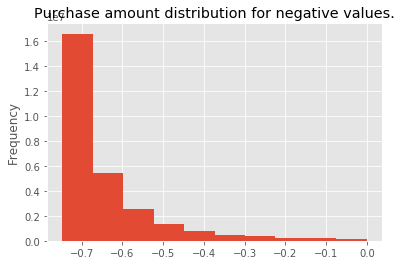

In [27]:
plt.title('Purchase amount distribution for negative values.');
historical_transactions.loc[historical_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

### 거의 모든 거래가 -1 ~ 0 사이에 있음, 높은 특이점과 표준분포를 따름


# Categories

In [28]:
map_dict = {'Y': 0, 'N': 1}
historical_transactions['category_1'] = historical_transactions['category_1'].apply(lambda x: map_dict[x])
historical_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

purchase_amount                        authorized_flag          
                      mean          std     count            mean       std
category_1                                                                 
0                -0.419327    22.087594   2084029        0.748578  0.433830
1                 0.071540  1166.016045  27028332        0.926265  0.261339